# **Environment Setup & Data Read**

Here, we import Pandas for data processing. We check to see the memory usage of the dataframe read in. Given that the dataframe can comfortable fit within the memory of the machine we are using, we can confidently continue with Pandas. Had this not been the case, we would have proceeded with Pyspark for data processing. As an additional note, we choose to download the file and load it locally instead of from S3 because the file is of a manageable size and the long-term durability of the S3 endpoint is not known.

We also import a custom-made utils module that contains code for tasks that will likely be repeated. Defining these functions in a separate module helps make the code more streamlined and readable. 

In [88]:
# Import general libraries
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform
from tqdm import tqdm 
import matplotlib.pyplot as plt

# Customize Jupyter output
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Import libraries for model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# Importing custom modules
from importlib import reload
import utils as ut

reload_condition = True
if reload_condition:
    reload(ut)

In [6]:
# Read in data from local parquet file
strike_df = pd.read_parquet('strikedata.parquet')

# Check memory usage
memory_gb = strike_df.memory_usage(deep=True).sum() / 1000000000
print('Memory usage of dataframe is {:.2f} GB'.format(memory_gb))

Memory usage of dataframe is 0.29 GB


In [7]:
# Quick view of data structure
strike_df.head(5)

,PITCH_KEY,GAMEPK,GAME_DATE,INNING_HALF,Year,League_ID,PITCHER_ID,PITCHER_SIDE,BATTER_ID,BATTER_SIDE,BATTER_HEIGHT_IN,OUTS,BALLS,STRIKES,PITCH_RELEASE_VELO,TRACK_RELEASE_SIDE,TRACK_RELEASE_HEIGHT,TRACK_RELEASE_ANGLE_VERT,TRACK_RELEASE_ANGLE_HORIZ,TRACK_RELEASE_EXTENSION,TRACK_APPR_ACCEL_X,TRACK_APPR_ACCEL_Y,TRACK_APPR_ACCEL_Z,TRACK_PLATE_X,TRACK_PLATE_Z,pitch_outcome_id,pitch_outcome_name
0,95136416,529416,2018-03-29,1,2018,NL,595465,R,467793,L,71.0,1,2,2,94.283073,1.836442,5.360555,0.161273,-1.563570,6.016098,-9.185337,34.856476,-12.551595,1.061653,4.490934,2,Ball
1,95100329,529416,2018-03-29,1,2018,NL,595465,R,467793,L,71.0,1,0,1,90.900421,2.021586,5.178264,-0.484359,-3.559973,5.933589,4.973417,26.203642,-23.254955,-1.857962,2.691414,2,Ball
2,95142428,529416,2018-03-29,1,2018,NL,595465,R,467793,L,71.0,1,1,2,93.970642,1.821961,5.295847,0.196058,-1.273360,5.946202,-10.126297,30.844500,-13.260889,1.410896,4.404634,2,Ball
3,95221378,529416,2018-03-29,1,2018,NL,595465,R,467793,L,71.0,1,0,0,94.036186,1.948989,5.279838,-1.056873,-2.766224,6.102707,-6.981641,31.926218,-14.742636,-0.168085,3.052946,8,StrikeCalled
4,95026181,529416,2018-03-29,1,2018,NL,527054,R,595284,L,73.0,2,0,0,89.912376,1.961421,5.048395,-0.930966,-1.640306,5.997355,-6.523272,27.654985,-16.904480,0.950111,2.644435,8,StrikeCalled
5,95026291,529416,2018-03-29,1,2018,NL,527054,R,595284,L,73.0,2,1,2,78.949875,1.772668,4.773604,-1.544461,-4.047848,5.718820,2.997156,21.608366,-30.319881,-2.534204,-0.290358,2,Ball
6,95103728,529416,2018-03-29,1,2018,NL,527054,R,595284,L,73.0,2,0,2,89.338638,2.067608,5.037737,0.724991,-2.644353,6.145785,-8.351307,27.049145,-17.334429,0.257906,4.188417,2,Ball
7,95195931,529416,2018-03-29,2,2018,NL,605400,R,527054,R,74.0,0,0,0,90.342262,2.047164,4.903065,-1.512953,-3.687308,6.352959,-13.517827,28.186758,-17.492699,-0.331193,1.917746,8,StrikeCalled
8,95122168,529416,2018-03-29,2,2018,NL,605400,R,527054,R,74.0,0,0,1,75.881744,2.138564,5.090311,1.571812,-0.327449,6.097074,12.443213,22.932608,-40.095657,0.249492,1.565629,8,StrikeCalled
9,95242769,529407,2018-03-29,2,2018,NL,518553,R,516770,R,74.0,1,1,1,77.345551,3.512944,4.336934,1.872215,-0.826135,6.885411,14.352231,26.304304,-34.224911,1.005561,2.069280,8,StrikeCalled


# **Exploratory Data Analysis**

## Data Cleaning & Initial Exploration

### Missing Values

We check for missing values in our dataset in the form of null values, nan values, and blank values. If we had seen missing values, we would have considered dropping the rows or imputing values to fill in the missing data points. 

In [8]:
# Missing Value Checks
strike_df[(strike_df.isnull().any(axis=1)) | (strike_df.isna().any(axis=1)) | (strike_df == '').any(axis=1)]

,PITCH_KEY,GAMEPK,GAME_DATE,INNING_HALF,Year,League_ID,PITCHER_ID,PITCHER_SIDE,BATTER_ID,BATTER_SIDE,BATTER_HEIGHT_IN,OUTS,BALLS,STRIKES,PITCH_RELEASE_VELO,TRACK_RELEASE_SIDE,TRACK_RELEASE_HEIGHT,TRACK_RELEASE_ANGLE_VERT,TRACK_RELEASE_ANGLE_HORIZ,TRACK_RELEASE_EXTENSION,TRACK_APPR_ACCEL_X,TRACK_APPR_ACCEL_Y,TRACK_APPR_ACCEL_Z,TRACK_PLATE_X,TRACK_PLATE_Z,pitch_outcome_id,pitch_outcome_name


### Data Ranges Checks - Categorical

We produce some output to understand the general bounds of our data. Specifically, we confirm that our variables have values that make sense and we get a rough understanding of how our data is partitioned (in this case checking to see the number of games, pitchers, and batters in our dataset).

In [9]:
cat_variables = ['PITCH_KEY', 'GAMEPK', 'GAME_DATE', 'INNING_HALF', 'Year', 'League_ID',
                 'PITCHER_ID', 'PITCHER_SIDE', 'BATTER_ID', 'BATTER_SIDE',
                 'OUTS', 'BALLS', 'STRIKES', 'pitch_outcome_id', 'pitch_outcome_name']

variable_range_data = {}
for variable in cat_variables:
    variable_range_data[variable] = strike_df[variable].unique()

In [10]:
# Confirm that each pitch has a unique pitch ID
print('Each Row has a Unique Pitch ID: ', len(variable_range_data['PITCH_KEY']) == len(strike_df))

# Confirm that inning half is either 1 or 2
print('Inning Half is either 1 or 2: ', len(variable_range_data['INNING_HALF']) == 2)

# Confirm that pitcher side and batter side are R or L
print('Pitcher Side is either R or L: ', len(variable_range_data['PITCHER_SIDE']) == 2)
print('Batter Side is either R or L: ', len(variable_range_data['BATTER_SIDE']) == 2)

# Confirm that outs is between 0 and 2
print('Outs is between 0 and 2: ', len(variable_range_data['OUTS']) == 3)

# Confirm that balls is between 0 and 3 and strikes is between 0 and 2
print('Balls is between 0 and 3: ', len(variable_range_data['BALLS']) == 4)
print('Strikes is between 0 and 2: ', len(variable_range_data['STRIKES']) == 3)

# Count number of unique games 
print('')
print('Number of Unique Game Primary Keys: ', len(variable_range_data['GAMEPK']))
print('Number of Unique Pitcher IDs: ', len(variable_range_data['PITCHER_ID']))
print('Number of Unique Batter IDs: ', len(variable_range_data['BATTER_ID']))

Each Row has a Unique Pitch ID:  True
Inning Half is either 1 or 2:  True
Pitcher Side is either R or L:  True
Batter Side is either R or L:  True
Outs is between 0 and 2:  True
Balls is between 0 and 3:  True
Strikes is between 0 and 2:  True

Number of Unique Game Primary Keys:  4817
Number of Unique Pitcher IDs:  1033
Number of Unique Batter IDs:  1213


### Variable Value Breakdown - Categorical

In lieu of a traditional "distribution" of data for our categorical variables, we instead opt of a breakdown of value counts. For each of our categorical variables, we understand the values the variables may take and the associated frequency of those values. We omit certain categorical variables that do not seem instrumental, such as primary keys. 

In [11]:
cat_variables = ['PITCH_KEY', 'GAMEPK', 'GAME_DATE', 'INNING_HALF', 'Year', 'League_ID',
                 'PITCHER_ID', 'PITCHER_SIDE', 'BATTER_ID', 'BATTER_SIDE',
                 'OUTS', 'BALLS', 'STRIKES', 'pitch_outcome_id', 'pitch_outcome_name']

# Get breakdown of variables

# Breakdown of Year
print('Distribution of Year Variable')
print(strike_df['Year'].value_counts())
print('')

# Breakdown of League ID
print('Distribution of League_ID Variable')
print(strike_df['League_ID'].value_counts())
print('')

# Breakdown of Pitcher Side
print('Distribution of PITCHER_SIDE Variable')
print(strike_df['PITCHER_SIDE'].value_counts())
print('')

# Breakdown of Batter Side
print('Distribution of BATTER_SIDE Variable')
print(strike_df['BATTER_SIDE'].value_counts())
print('')

Distribution of Year Variable
Year
2019    378191
2018    277763
Name: count, dtype: int64

Distribution of League_ID Variable
League_ID
AL    330341
NL    325613
Name: count, dtype: int64

Distribution of PITCHER_SIDE Variable
PITCHER_SIDE
R    468553
L    187401
Name: count, dtype: int64

Distribution of BATTER_SIDE Variable
BATTER_SIDE
R    382024
L    273930
Name: count, dtype: int64



### Data Distributions - Continuous

For our continuous variables, we can get a sense of both the bounds and the distribution of our data by generating traditional distribution plots. We generate both a continuous historgram and a box and whisker plot to visualize both the distribution of the data along with summary statistics of that data that can tell us aggregate statistics and identify potential outliers. 

The code for generating these plots is stored in our custom module `utils.py` in order to remove code clutter from this notebook. In our custom module, we also have a function to easily generate summary statistics of a column. The functionality is displayed below. 

In [12]:
# Define our set of continuous variables
cont_variables = strike_df.columns.difference(cat_variables)

In [104]:
# Functionality for producing numeric summary statistics
variable_name = 'BATTER_HEIGHT_IN'

print('Summary Statistics for:', variable_name)
ut.get_summary_statistics(strike_df[variable_name])

Summary Statistics for : BATTER_HEIGHT_IN


{'mean': 73.05640944334512,
 'median': 73.0,
 'min': 66.0,
 'max': 80.0,
 'std': 2.20982225776339}

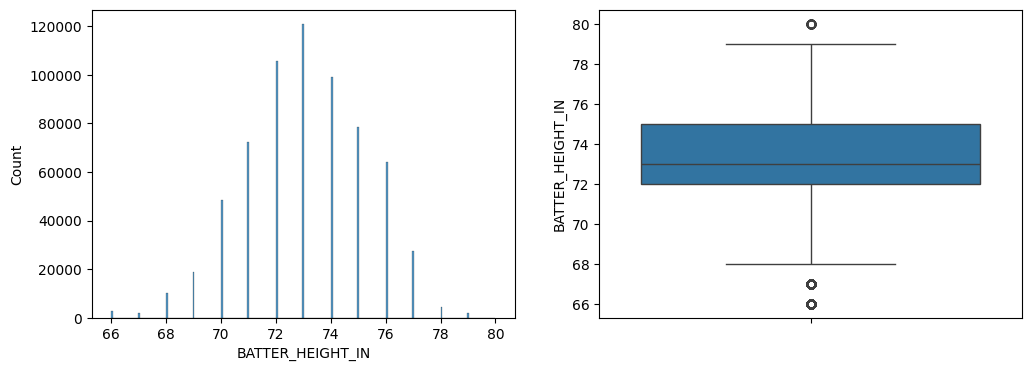

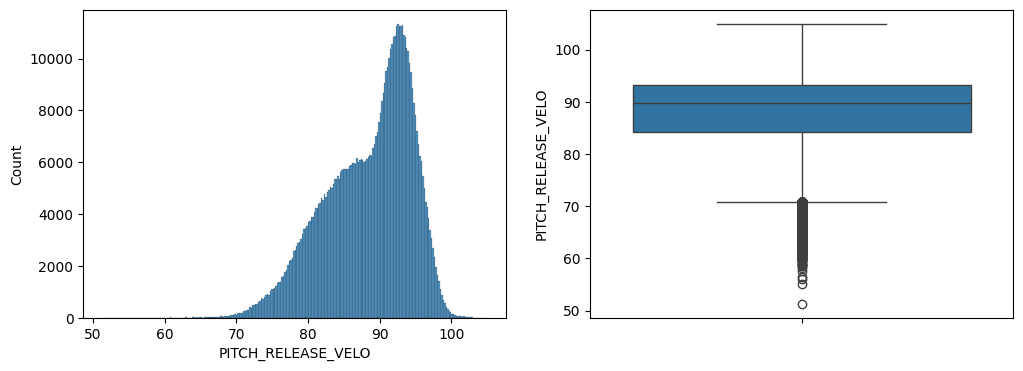

KeyboardInterrupt: 

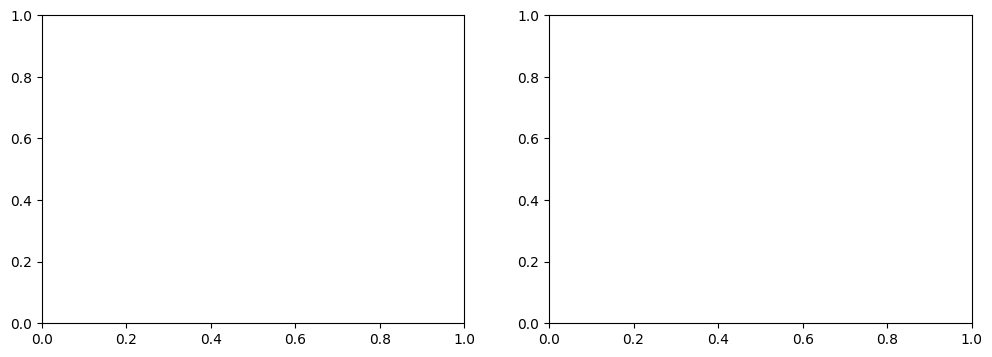

In [13]:
# Plot distributions for all continuous variables
ut.plot_distribution(strike_df['BATTER_HEIGHT_IN'])
ut.plot_distribution(strike_df['PITCH_RELEASE_VELO'])
ut.plot_distribution(strike_df['TRACK_APPR_ACCEL_X'])
ut.plot_distribution(strike_df['TRACK_APPR_ACCEL_Y'])
ut.plot_distribution(strike_df['TRACK_APPR_ACCEL_Z'])
ut.plot_distribution(strike_df['TRACK_PLATE_X'])
ut.plot_distribution(strike_df['TRACK_PLATE_Z'])
ut.plot_distribution(strike_df['TRACK_RELEASE_ANGLE_HORIZ'])
ut.plot_distribution(strike_df['TRACK_RELEASE_ANGLE_VERT'])
ut.plot_distribution(strike_df['TRACK_RELEASE_EXTENSION'])
ut.plot_distribution(strike_df['TRACK_RELEASE_HEIGHT'])
ut.plot_distribution(strike_df['TRACK_RELEASE_SIDE'])

### A Note on Interpreting Data 

To interpet the data, we use the following Statcast Documentation (https://baseballsavant.mlb.com/csv-docs#plate_x). In the event that this interpretation is incorrect, we must go back and make adjustments. However, the code built here is flexible enough to reproduce results quickly.

### Heat Map Generator

The function below allows users to get a heatmap of pitches (either all pitches or strikes only) broken down by a variable that the user can supply as well. This visualization helps us understand and communicate the link that a single variable can have with observed pitches. We select two samples to display in this notebook, one with Batter Height and another with Batter Side. For Batter Height, we can observe that the observed hot strike zone (area where many strikes are thrown) is higher with higher Batter Heights, as expected. For Batter Side, we can see the location of all pitches thrown move from side to side when we subset on Right-Handed hitters versus Left-Handed Hitters. 

In the cell immediately, below, we include a heatmap for all pitches thrown and all strikes through regardless of any variable interaction to serve as a reference point. Predictably, the largest concentrations of strikes thrown are found in the dead center of the strike zone.

Text(0, 0.5, 'TRACK_PLATE_Z')

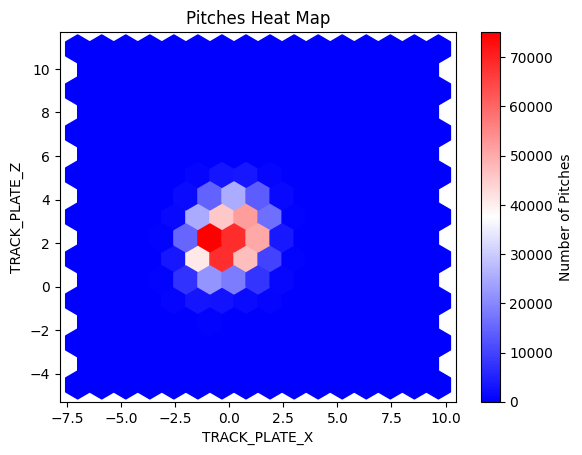

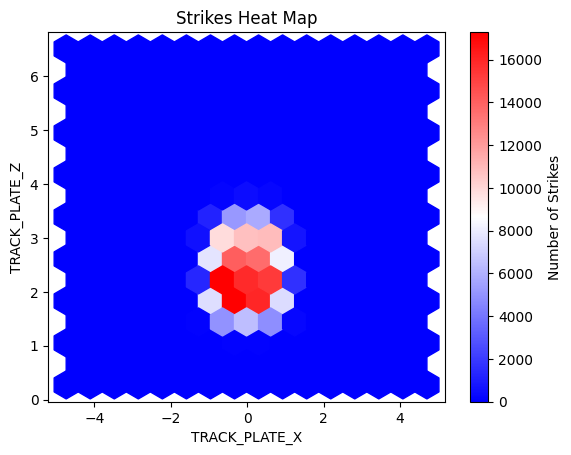

In [148]:
# Heatmap for All pitches
plt.figure(1)
hb = plt.hexbin(strike_df['TRACK_PLATE_X'], strike_df['TRACK_PLATE_Z'], gridsize=15, cmap='bwr')
plt.colorbar(hb, label='Number of Pitches')

# Add axis titles and legend
plt.title('Pitches Heat Map')
plt.xlabel('TRACK_PLATE_X')
plt.ylabel('TRACK_PLATE_Z')


# Heatmap for Strikes Only
strikes_only = strike_df[strike_df['pitch_outcome_name'] == 'StrikeCalled']

plt.figure(2)
hb2 = plt.hexbin(strikes_only['TRACK_PLATE_X'], strikes_only['TRACK_PLATE_Z'], gridsize=15, cmap='bwr')
plt.colorbar(hb2, label='Number of Strikes')

# Add axis titles and legend
plt.title('Strikes Heat Map')
plt.xlabel('TRACK_PLATE_X')
plt.ylabel('TRACK_PLATE_Z')

In [145]:
def show_heatmap(variable, variable_type, df=strike_df, strike_only=False):
    if strike_only:
        df = df[df['pitch_outcome_name'] == 'StrikeCalled']
        pitch_type = 'Strikes'
    else:
        pitch_type = 'Pitches'
    
    if variable_type == 'continuous':
        higher_df = df[df[variable] >= df[variable].median()]
        lower_df = df[df[variable] < df[variable].median()]

        plt.figure(1)
        hb = plt.hexbin(higher_df['TRACK_PLATE_X'], higher_df['TRACK_PLATE_Z'], gridsize=15, cmap='bwr')
        plt.colorbar(hb, label='Number of ' + pitch_type)

        # Add axis titles and legend
        plt.title(pitch_type + ' Heat Map when ' + variable + ' is Above Median Value')
        plt.xlabel('TRACK_PLATE_X')
        plt.ylabel('TRACK_PLATE_Z')

        plt.figure(2)
        hb2 = plt.hexbin(lower_df['TRACK_PLATE_X'], lower_df['TRACK_PLATE_Z'], gridsize=15, cmap='bwr')
        plt.colorbar(hb2, label='Number of ' + pitch_type)
        
        # Add axis titles and legend
        plt.title(pitch_type + ' Heat Map when ' + variable + ' is Below Median Value')
        plt.xlabel('TRACK_PLATE_X')
        plt.ylabel('TRACK_PLATE_Z')

        plt.show()

    else:
        for idx, cat_val in enumerate(df[variable].unique()):
        
            cat_df = df[df[variable] == cat_val]

            plt.figure(idx)
            hb = plt.hexbin(cat_df['TRACK_PLATE_X'], cat_df['TRACK_PLATE_Z'], gridsize=15, cmap='bwr')
            plt.colorbar(hb, label='Number of ' + pitch_type)
            plt.title(pitch_type + ' Heat Map when ' + variable + ' is equal to ' + str(cat_val))
            plt.xlabel('TRACK_PLATE_X')
            plt.ylabel('TRACK_PLATE_Z')

Sample Output for Batter Height (continuous variable) with Strike Only turned to True

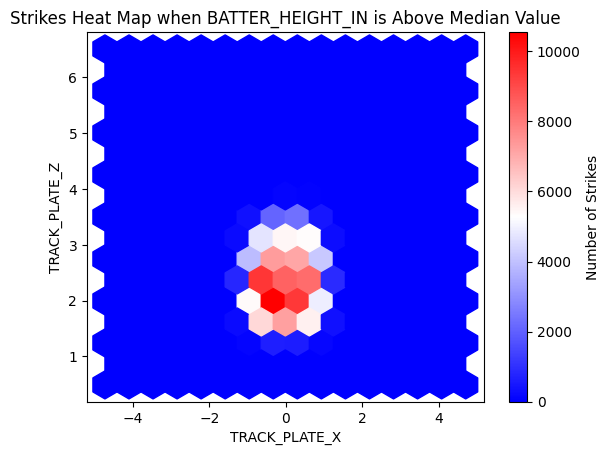

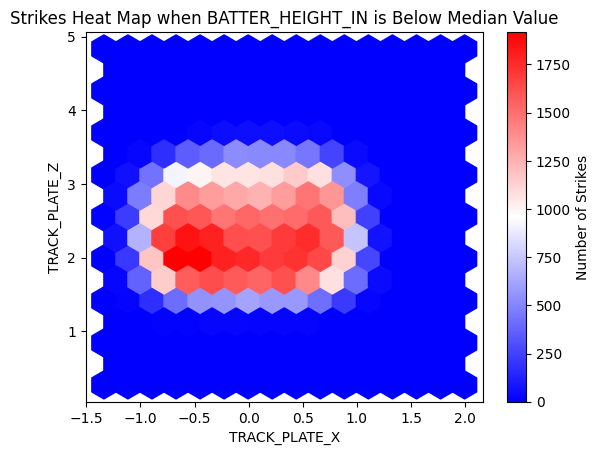

In [144]:
show_heatmap('BATTER_HEIGHT_IN', 'continuous', df=strike_df, strike_only=True)

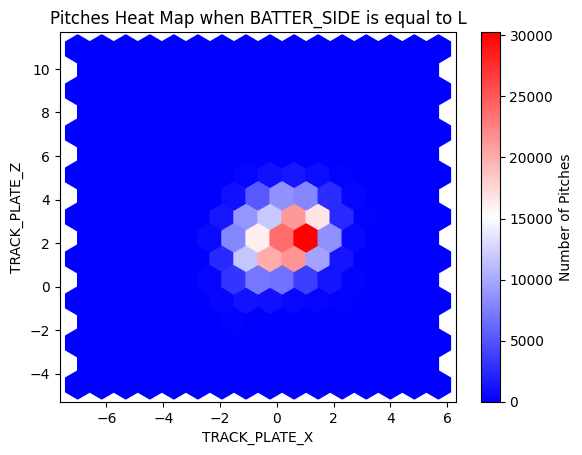

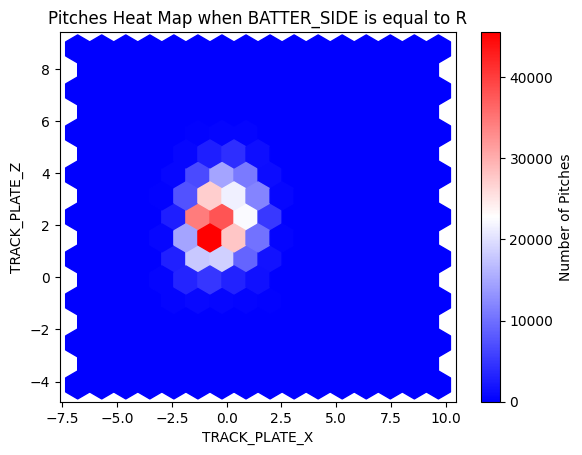

In [146]:
show_heatmap('BATTER_SIDE', 'categorical', df=strike_df, strike_only=False)

## Variable Redefinition

### Categorical Variables

In [14]:
# Extract month from game date
strike_df['GAME_DATE'] = pd.to_datetime(strike_df['GAME_DATE'])
strike_df['GAME_MONTH'] = strike_df['GAME_DATE'].dt.month

In [15]:
# Concatenate pitcher side and batter side to create batter pitcher side
strike_df['PITCHER_BATTER_SIDE'] = strike_df['PITCHER_SIDE'] + '_' + strike_df['BATTER_SIDE']
strike_df['PITCHER_BATTER_SIDE'].value_counts()

PITCHER_BATTER_SIDE
R_R    247283
R_L    221270
L_R    134741
L_L     52660
Name: count, dtype: int64

In [16]:
# Concatenate balls and strikes to create count
strike_df['COUNT'] = strike_df['BALLS'].astype(str) + '_' + strike_df['STRIKES'].astype(str)
strike_df['COUNT'].value_counts()

COUNT
0_0    223091
0_1     83080
1_0     71250
1_1     58828
1_2     50841
0_2     39831
2_2     36377
2_1     27727
2_0     23750
3_2     17455
3_1     12144
3_0     11580
Name: count, dtype: int64

### Target Variable

In [47]:
target_replace_dict = {2: 0, 8:1}
strike_df['pitch_outcome_id'] = strike_df['pitch_outcome_id'].replace(target_replace_dict)

## Target Variable Exploration

In [17]:
print('Distribution of Pitch Outcome')
print(strike_df['pitch_outcome_name'].value_counts())
print('')
print(strike_df['pitch_outcome_id'].value_counts())

Distribution of Pitch Outcome
pitch_outcome_name
Ball            448790
StrikeCalled    207164
Name: count, dtype: int64

pitch_outcome_id
2    448790
8    207164
Name: count, dtype: int64


In [48]:
# Create a dictionary using pitch outcome name and id columns
pitch_outcome_dict = dict(zip(strike_df['pitch_outcome_name'], strike_df['pitch_outcome_id']))
pitch_outcome_dict

{'Ball': 0, 'StrikeCalled': 1}

### Correlation Analysis - Categorical

In [19]:
cat_variables_slim = ['GAME_MONTH', 'INNING_HALF', 'Year', 'League_ID', 'PITCHER_SIDE', 'BATTER_SIDE', 'OUTS', 'BALLS',
                      'STRIKES', 'COUNT']
 
for cat_var in cat_variables_slim:
    print(cat_var)
    cat_var_dict = ut.get_target_correlation(strike_df, cat_var, 'categorical', target='pitch_outcome_id')
    cat_var_df = pd.DataFrame.from_dict(cat_var_dict, orient='index', columns=['Difference', 'P-Value'])
    cat_var_df['Difference'] = cat_var_df['Difference'] * 100
    print(cat_var_df)
    print('')

GAME_MONTH


    Difference  P-Value
3          0.2    0.650
4          0.5    0.003
7         -0.1    0.501
8         -0.1    0.598
9         -0.3    0.058
6         -0.2    0.336
5          0.2    0.264
10        -1.6    0.565

INNING_HALF
   Difference  P-Value
1         0.5      0.0
2        -0.5      0.0

Year
      Difference  P-Value
2018         0.6      0.0
2019        -0.6      0.0

League_ID
    Difference  P-Value
NL         0.2    0.037
AL        -0.2    0.037

PITCHER_SIDE
   Difference  P-Value
R         0.1    0.427
L        -0.1    0.427

BATTER_SIDE
   Difference  P-Value
L        -1.5      0.0
R         1.5      0.0

OUTS
   Difference  P-Value
1        -0.5      0.0
2        -1.7      0.0
0         2.2      0.0

BALLS
   Difference  P-Value
2        -5.2      0.0
0         6.5      0.0
1        -7.0      0.0
3         6.3      0.0

STRIKES
   Difference  P-Value
2       -25.8      0.0
1       -10.1      0.0
0        25.9      0.0

COUNT
     Difference  P-Value
2_2       -18.8  

In [27]:
for cont_var in cont_variables:
    cont_var_dict = ut.get_target_correlation(strike_df, cont_var, 'continuous', target='pitch_outcome_id')
    cont_var_df = pd.DataFrame.from_dict(cont_var_dict, orient='index', columns=['Difference', 'Diff as Pct of Range', 'P-Value'])
    print(cont_var_df)
    print('')

                  Difference  Diff as Pct of Range  P-Value
BATTER_HEIGHT_IN      -0.055                 -0.39      0.0

                    Difference  Diff as Pct of Range  P-Value
PITCH_RELEASE_VELO       0.263                  0.49      0.0

                    Difference  Diff as Pct of Range  P-Value
TRACK_APPR_ACCEL_X      -0.047                 -0.07    0.095

                    Difference  Diff as Pct of Range  P-Value
TRACK_APPR_ACCEL_Y       0.119                  0.34      0.0

                    Difference  Diff as Pct of Range  P-Value
TRACK_APPR_ACCEL_Z       0.711                  0.85      0.0

               Difference  Diff as Pct of Range  P-Value
TRACK_PLATE_X       0.066                  0.39      0.0

               Difference  Diff as Pct of Range  P-Value
TRACK_PLATE_Z        0.25                  1.62      0.0

                           Difference  Diff as Pct of Range  P-Value
TRACK_RELEASE_ANGLE_HORIZ       0.064                  0.35      0.0

          

# **Modeling**

## Data Preprocessing

In [49]:
strike_df = strike_df.sample(frac=1)

In [50]:
model_variables = ['GAME_MONTH', 'INNING_HALF', 'League_ID', 'PITCHER_SIDE', 'BATTER_SIDE', 'BATTER_HEIGHT_IN',
                   'OUTS', 'BALLS', 'STRIKES', 'PITCH_RELEASE_VELO', 'TRACK_RELEASE_SIDE', 'TRACK_RELEASE_HEIGHT',
                   'TRACK_RELEASE_ANGLE_VERT', 'TRACK_RELEASE_ANGLE_HORIZ', 'TRACK_RELEASE_EXTENSION', 
                   'TRACK_APPR_ACCEL_X', 'TRACK_APPR_ACCEL_Y','TRACK_APPR_ACCEL_Z', 'TRACK_PLATE_X', 'TRACK_PLATE_Z', 
                   'PITCHER_BATTER_SIDE', 'COUNT']

strike_X = strike_df[model_variables]
strike_y = strike_df['pitch_outcome_id']

### One Hot Encoding

In [51]:
game_month_dummies = pd.get_dummies(strike_X['GAME_MONTH'], prefix='GAME_MONTH')
inning_half_dummies = pd.get_dummies(strike_X['INNING_HALF'], prefix='INNING_HALF')
league_id_dummies = pd.get_dummies(strike_X['League_ID'], prefix='League_ID')
pitcher_side_dummies = pd.get_dummies(strike_X['PITCHER_SIDE'], prefix='PITCHER_SIDE')
batter_side_dummies = pd.get_dummies(strike_X['BATTER_SIDE'], prefix='BATTER_SIDE')
outs_dummies = pd.get_dummies(strike_X['OUTS'], prefix='OUTS')
balls_dummies = pd.get_dummies(strike_X['BALLS'], prefix='BALLS')
strikes_dummies = pd.get_dummies(strike_X['STRIKES'], prefix='STRIKES')
pitcher_batter_side_dummies = pd.get_dummies(strike_X['PITCHER_BATTER_SIDE'], prefix='PITCHER_BATTER_SIDE')
count_dummies = pd.get_dummies(strike_X['COUNT'], prefix='COUNT')

strike_X = pd.concat([strike_X, game_month_dummies, inning_half_dummies, league_id_dummies, pitcher_side_dummies,
                        batter_side_dummies, outs_dummies, balls_dummies, strikes_dummies, pitcher_batter_side_dummies,
                        count_dummies], axis=1)

strike_X = strike_X.drop(['GAME_MONTH', 'INNING_HALF', 'League_ID', 'PITCHER_SIDE', 'BATTER_SIDE', 'OUTS', 'BALLS',
                            'STRIKES', 'PITCHER_BATTER_SIDE', 'COUNT'], axis=1)

strike_X.head(10)

,BATTER_HEIGHT_IN,PITCH_RELEASE_VELO,TRACK_RELEASE_SIDE,TRACK_RELEASE_HEIGHT,TRACK_RELEASE_ANGLE_VERT,TRACK_RELEASE_ANGLE_HORIZ,TRACK_RELEASE_EXTENSION,TRACK_APPR_ACCEL_X,TRACK_APPR_ACCEL_Y,TRACK_APPR_ACCEL_Z,TRACK_PLATE_X,TRACK_PLATE_Z,GAME_MONTH_3,GAME_MONTH_4,GAME_MONTH_5,GAME_MONTH_6,GAME_MONTH_7,GAME_MONTH_8,GAME_MONTH_9,GAME_MONTH_10,INNING_HALF_1,INNING_HALF_2,League_ID_AL,League_ID_NL,PITCHER_SIDE_L,PITCHER_SIDE_R,BATTER_SIDE_L,BATTER_SIDE_R,OUTS_0,OUTS_1,OUTS_2,BALLS_0,BALLS_1,BALLS_2,BALLS_3,STRIKES_0,STRIKES_1,STRIKES_2,PITCHER_BATTER_SIDE_L_L,PITCHER_BATTER_SIDE_L_R,PITCHER_BATTER_SIDE_R_L,PITCHER_BATTER_SIDE_R_R,COUNT_0_0,COUNT_0_1,COUNT_0_2,COUNT_1_0,COUNT_1_1,COUNT_1_2,COUNT_2_0,COUNT_2_1,COUNT_2_2,COUNT_3_0,COUNT_3_1,COUNT_3_2
379752,72.0,74.468842,3.350712,1.743114,4.052488,-0.906463,5.816705,3.361628,18.950428,-31.457493,2.028458,1.573896,False,False,True,False,False,False,False,False,False,True,True,False,False,True,True,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
218318,73.0,88.269165,-1.264525,5.944880,-2.285772,3.611060,6.208069,15.427915,23.299990,-25.130754,0.806268,1.465999,False,False,False,False,True,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
264931,72.0,93.067017,0.868505,5.686286,-2.959278,-1.726795,6.880591,-6.216605,28.673513,-13.532025,-0.277186,1.785481,False,True,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False
394519,75.0,87.134804,2.167071,5.611299,-3.089861,-4.784269,7.567430,-10.110516,25.238060,-19.367565,-1.429640,0.966871,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,True,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False
203729,74.0,94.688522,-1.592880,6.308084,-2.662166,0.801317,5.374986,5.913534,29.810379,-10.982648,-1.292026,2.797171,False,False,False,False,False,False,True,False,False,True,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
591263,76.0,94.868568,2.586320,6.223080,-3.204734,-6.048285,5.936042,-22.959991,30.820698,-21.805450,-1.447234,1.320829,True,False,False,False,False,False,False,False,False,True,True,False,False,True,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
603873,74.0,94.366402,-2.111621,6.215104,-3.297692,0.946440,5.352582,5.875061,29.494955,-16.973045,-1.669261,1.575568,False,True,False,False,False,False,False,False,True,False,False,True,True,False,False,True,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
363347,75.0,89.971115,1.305467,5.550267,-0.472110,-1.736403,6.651811,-4.000854,32.963577,-14.762798,-0.019853,3.795018,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
267976,73.0,92.102585,3.021348,5.622575,-2.437298,-3.619389,5.964701,-16.060822,27.768080,-19.236652,0.874544,1.625140,False,False,False,False,False,True,False,False,True,False,True,False,False,True,True,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False
59

## Prototype I: XGBoost

### Train Test Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(strike_X, strike_y, test_size=0.2)

In [94]:
np.linspace(0.01, 0.1, 10)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

### Run and Evaluate

In [95]:
model = XGBClassifier(verbosity = 0)

param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 12),
    'max_leaves': [0],
    'gamma': np.linspace(0, 0.1, 20),
    'learning_rate': np.linspace(0.01, 0.1, 10),
    'colsample_bytree': np.linspace(0.4, 0.95, 10),
    'booster': ['gbtree']
}

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=50, 
    scoring='f1', 
    cv=3,
    verbose=10,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3; 1/50] START booster=gbtree, colsample_bytree=0.7666666666666666, gamma=0.1, learning_rate=0.08, max_depth=9, max_leaves=0, n_estimators=70
[CV 2/3; 2/50] START booster=gbtree, colsample_bytree=0.7666666666666666, gamma=0.09473684210526316, learning_rate=0.07, max_depth=7, max_leaves=0, n_estimators=137
[CV 1/3; 2/50] START booster=gbtree, colsample_bytree=0.7666666666666666, gamma=0.09473684210526316, learning_rate=0.07, max_depth=7, max_leaves=0, n_estimators=137
[CV 1/3; 3/50] START booster=gbtree, colsample_bytree=0.6444444444444444, gamma=0.015789473684210527, learning_rate=0.08, max_depth=7, max_leaves=0, n_estimators=199
[CV 1/3; 1/50] START booster=gbtree, colsample_bytree=0.7666666666666666, gamma=0.1, learning_rate=0.08, max_depth=9, max_leaves=0, n_estimators=70
[CV 2/3; 1/50] START booster=gbtree, colsample_bytree=0.7666666666666666, gamma=0.1, learning_rate=0.08, max_depth=9, max_leaves=0, n_estimators=7

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
       0.07894737, 0.08421053, 0.08947368, 0.09473684, 0.1       ]),
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x153e80790>,
                                        'max_leaves': [0],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1683fb190>},
                   random_state=42, scoring='f1', verbose=10)

In [100]:
best_classifier = random_search.best_estimator_
best_classifier

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7666666666666666, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.042105263157894736,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=429, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [101]:
predictions = best_classifier.predict(X_test)
accuracy_score(y_test, predictions)

0.9319313062633869

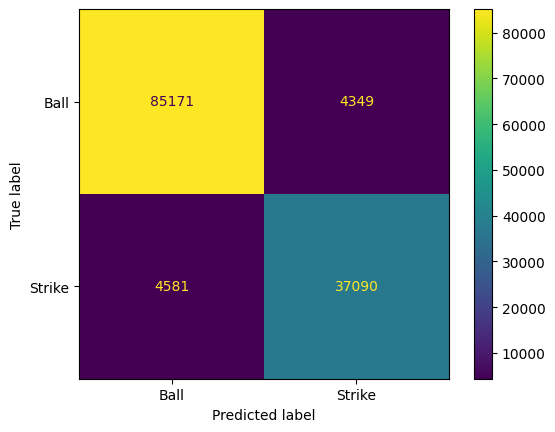

In [102]:
cm = confusion_matrix(predictions, y_test)
ConfusionMatrixDisplay(cm, display_labels=['Ball', 'Strike']).plot()